In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch

In [3]:
from sklearn.decomposition import PCA
import umap

In [4]:
df = pd.read_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/processed_reviews.csv"
)

In [5]:
df.head()

,rating,review_length_text,review_length_title,polarity_text,polarity_title,subjectivity_text,subjectivity_title,lemmatized_text,lemmatized_title,day_of_week,month,year
0,1,408,2,0.018448,-1.0,0.512241,1.0,"['often', 'last', 'first', 'purchase', 'luggag...","['bad', 'airline']",Wednesday,11,2024
1,1,157,4,-0.060897,-1.0,0.592949,1.0,"['regard', 'booking', 'accommodation', 'regard...","['terrible', 'experience', 'airfrance']",Wednesday,11,2024
2,1,259,11,-0.094163,-0.6,0.488287,0.7,"['sky', 'sky', 'staff', 'amount', 'without', '...","['extremely', 'disappointing', 'experience', '...",Tuesday,11,2024
3,1,274,1,-0.109373,-1.0,0.494012,1.0,"['I', 've', 'always', 'shock', 'first', 'check...",['horrible'],Monday,11,2024
4,1,311,7,-0.126476,-1.0,0.485192,1.0,"['family', 'ruin', 'arrive', 'check', 'counter...","['bad', 'flight', 'experience', 'I', 've', 'ev...",Monday,11,2024


In [6]:
bow_vectorizer = CountVectorizer(max_features=10000, min_df=5, stop_words="english")
X_bow = bow_vectorizer.fit_transform(df["lemmatized_text"].astype(str))

df_bow = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bow_vectorized.pkl",
    "wb",
) as f:
    pickle.dump(df_bow, f)

df_bow.head()

,able,accept,acceptable,access,accommodate,accommodation,account,addition,additional,address,...,wish,woman,word,world,worry,worth,write,wrong,young,zero
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5,
)

# Fit and transform lemmatized text
X_tfidf = tfidf_vectorizer.fit_transform(df["lemmatized_text"].astype(str))
df_tfidf = pd.DataFrame(
    X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# Save TF-IDF matrix
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/tfidf_vectorized.pkl",
    "wb",
) as f:
    pickle.dump(df_tfidf, f)


df_tfidf.head()

,able,able booking,able check,able sleep,able stretch,accept,acceptable,access,access lounge,accommodate,...,world food,worry,worth,worth cost,worth extra,worth money,write,wrong,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.148274,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
tokenized_reviews = [text.split() for text in df["lemmatized_text"].astype(str)]

word2vec_model = Word2Vec(
    sentences=tokenized_reviews, vector_size=100, window=5, min_count=5, workers=4
)


def get_word2vec_embeddings(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)


df["word2vec_embedding"] = df["lemmatized_text"].apply(get_word2vec_embeddings)

# Convert embeddings to a list (needed for pickle)
word2vec_embeddings = df["word2vec_embedding"].tolist()

# Save Word2Vec embeddings
word2vec_path = "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_vectorized.pkl"
with open(word2vec_path, "wb") as f:
    pickle.dump(word2vec_embeddings, f)

print(f"Word2Vec embeddings successfully saved to {word2vec_path}")

df[["word2vec_embedding"]].head()

Word2Vec embeddings successfully saved to /home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_vectorized.pkl


,word2vec_embedding
0,"[-0.13749978, 0.11485775, -0.0067502838, 0.056..."
1,"[-0.123924986, 0.12251827, -0.012798673, 0.049..."
2,"[-0.12134098, 0.1167562, -0.012363002, 0.04818..."
3,"[-0.1296919, 0.11864889, -0.0144240325, 0.0496..."
4,"[-0.12922546, 0.116927154, -0.013109679, 0.050..."


In [9]:
import torch

print("Torch CUDA available:", torch.cuda.is_available())  # Should be True
print("Torch Version:", torch.__version__)  # Should show a version with cu121
print("Number of GPUs:", torch.cuda.device_count())  # Should be at least 1
print("GPU Name:", torch.cuda.get_device_name(0))  # Should print Tesla T4

Torch CUDA available: True
Torch Version: 2.5.1+cu121
Number of GPUs: 1
GPU Name: Tesla T4


In [10]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


def get_bert_embeddings(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(
        device
    )
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy().flatten()


df["bert_embedding"] = df["lemmatized_text"].apply(get_bert_embeddings)

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bert_vectorized.pkl",
    "wb",
) as f:
    pickle.dump(df["bert_embedding"].tolist(), f)

print("BERT embeddings successfully saved to bert_vectorized.pkl")

df[["bert_embedding"]].head()

Using device: cuda


BERT embeddings successfully saved to bert_vectorized.pkl


,bert_embedding
0,"[-0.44602662, 0.8797275, 0.33837003, -0.229651..."
1,"[-0.23367932, 0.4675497, 0.4808056, -0.1928337..."
2,"[-0.16964142, 0.35025525, 0.4538577, -0.141660..."
3,"[-0.26111656, 0.47230378, 0.5266835, -0.028623..."
4,"[-0.014191495, 0.6086329, 0.52217776, -0.14459..."


In [11]:
from sklearn.decomposition import PCA
import umap

In [12]:
pca = PCA(n_components=100)
X_tfidf_pca = pca.fit_transform(df_tfidf)

In [13]:
umap_model = umap.UMAP(n_components=2)
X_word2vec_umap = umap_model.fit_transform(df["word2vec_embedding"].tolist())

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/tfidf_pca.pkl",
    "wb",
) as f:
    pickle.dump(X_tfidf, f)

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_umap.pkl",
    "wb",
) as f:
    pickle.dump(X_word2vec_umap, f)


In [15]:
df_final_vectorized = pd.DataFrame(
    {
        "tfidf_pca": list(X_tfidf_pca),
        "word2vec_umap": list(X_word2vec_umap),
        "bert_embedding": list(df["bert_embedding"]),
    }
)

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/vectorized_text.pkl",
    "wb",
) as f:
    pickle.dump(df_final_vectorized, f)

df_final_vectorized.head()

,tfidf_pca,word2vec_umap,bert_embedding
0,"[-0.30187285725759316, -0.23428221718628267, 0...","[-0.28833514, 12.596805]","[-0.44602662, 0.8797275, 0.33837003, -0.229651..."
1,"[0.005140449186289747, 0.10373114199908975, 0....","[2.2741067, 10.081238]","[-0.23367932, 0.4675497, 0.4808056, -0.1928337..."
2,"[0.01946833731302402, 0.008265850175747042, 0....","[1.185259, 5.561137]","[-0.16964142, 0.35025525, 0.4538577, -0.141660..."
3,"[0.03570188283087327, -0.09163218369076569, -0...","[1.9769892, 10.164197]","[-0.26111656, 0.47230378, 0.5266835, -0.028623..."
4,"[0.004219033965611748, 0.003783413591296188, 0...","[1.2925602, 8.801778]","[-0.014191495, 0.6086329, 0.52217776, -0.14459..."


In [16]:
print(f"TF-IDF Shape: {df_tfidf.shape}")

df_tfidf.head()

TF-IDF Shape: (2560, 1319)


,able,able booking,able check,able sleep,able stretch,accept,acceptable,access,access lounge,accommodate,...,world food,worry,worth,worth cost,worth extra,worth money,write,wrong,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.148274,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
vectorizer = TfidfVectorizer(
    max_features=10000, stop_words="english", ngram_range=(1, 2), min_df=5
)
vectorizer.fit(df["lemmatized_text"].astype(str))

feature_names = vectorizer.get_feature_names_out()
word_importance = df_tfidf.sum(axis=0)

df_tfidf_importance = pd.DataFrame(
    {"word": feature_names, "importance": word_importance}
)
df_tfidf_importance.sort_values(by="importance", ascending=False).head(20)


,word,importance
food,food,134.711045
staff,staff,97.400547
booking,booking,96.428725
check,check,95.497819
movie,movie,89.233387
luggage,luggage,74.344224
accommodation,accommodation,67.289907
cost,cost,65.850861
bag,bag,63.007350
meal,meal,60.073996


In [18]:
word2vec_model.save(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_model.bin"
)

In [19]:
similar_words = [
    word.strip("[]' ") for word in word2vec_model.wv.index_to_key if "serv" in word
]
print(similar_words)


["reserve',"]


In [20]:
print("service" in word2vec_model.wv.key_to_index)  # Should return True or False

False


In [21]:
print(word2vec_model.wv.index_to_key[:20])

["'food',", "'check',", "'booking',", "'luggage',", "'staff',", "'movie',", "'bag',", "'accommodation',", "'arrive',", "'cost',", "'transfer',", "'meal',", "'long',", "'first',", "'queue',", "'delayed',", "'boarding',", "'people',", "'board',", "'drink',"]


In [22]:
print(type(df["lemmatized_text"].iloc[0]))  # Check if it's a list or string

<class 'str'>


In [23]:
import ast  # Helps convert strings to lists safely

df["lemmatized_text"] = df["lemmatized_text"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [24]:
from gensim.models import Word2Vec

# Ensure every review is a list of words (not a string!)
sentences = df["lemmatized_text"].tolist()

# Train Word2Vec Model
word2vec_model = Word2Vec(
    sentences=sentences, vector_size=100, window=5, min_count=1, workers=4
)

# Save Model
word2vec_model.save("../data/interim/word2vec_model.bin")


In [25]:
word2vec_model = Word2Vec.load("../data/interim/word2vec_model.bin")

# Now check the first few words
print(word2vec_model.wv.index_to_key[:20])  # Should be clean words

# Check for a word again
print("service" in word2vec_model.wv.key_to_index)  # Should return True


['food', 'check', 'booking', 'staff', 'luggage', 'movie', 'bag', 'accommodation', 'cost', 'arrive', 'first', 'transfer', 'long', 'meal', 'delayed', 'boarding', 'queue', 'attendant', 'board', 'people']
False


In [26]:
import pickle

# Define paths
vector_files = {
    "TF-IDF": "../data/interim/tfidf_vectorized.pkl",
    "TF-IDF PCA": "../data/interim/tfidf_pca.pkl",
    "BoW": "../data/interim/bow_vectorized.pkl",
    "Word2Vec": "../data/interim/word2vec_vectorized.pkl",
    "Word2Vec UMAP": "../data/interim/word2vec_umap.pkl",
    "BERT": "../data/interim/bert_vectorized.pkl",
    "Vectorized Text": "../data/interim/vectorized_text.pkl",
}

# Load and check each file
for name, path in vector_files.items():
    try:
        with open(path, "rb") as f:
            data = pickle.load(f)
        print(f"\n{name} Shape: {data.shape if hasattr(data, 'shape') else len(data)}")
    except Exception as e:
        print(f"Error loading {name}: {e}")


TF-IDF Shape: (2560, 1319)

TF-IDF PCA Shape: (2560, 1319)

BoW Shape: (2560, 592)

Word2Vec Shape: 2560

Word2Vec UMAP Shape: (2560, 2)

BERT Shape: 2560

Vectorized Text Shape: (2560, 3)


In [27]:
key_terms = [
    "service",
    "food",
    "seat",
    "entertainment",
    "cabin",
    "crew",
    "flight",
    "airline",
    "pilot",
    "plane",
    "delay",
]

for term in key_terms:
    if term in word2vec_model.wv.key_to_index:
        print(f"\nMost similar words to '{term}':")
        print(word2vec_model.wv.most_similar(term, topn=5))
    else:
        print(f"\n '{term}' not found in Word2Vec model")


 'service' not found in Word2Vec model

Most similar words to 'food':
[('meal', 0.9984477758407593), ('wine', 0.9983990788459778), ('drink', 0.9982606172561646), ('snack', 0.9980122447013855), ('movie', 0.9977420568466187)]

 'seat' not found in Word2Vec model

 'entertainment' not found in Word2Vec model

 'cabin' not found in Word2Vec model

 'crew' not found in Word2Vec model

 'flight' not found in Word2Vec model

 'airline' not found in Word2Vec model

Most similar words to 'pilot':
[('plus', 0.9991257190704346), ('captain', 0.9991142153739929), ('sign', 0.9991061091423035), ('sit', 0.9990869760513306), ('thank', 0.9990818500518799)]

 'plane' not found in Word2Vec model

 'delay' not found in Word2Vec model


In [28]:
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bert_vectorized.pkl",
    "rb",
) as f:
    df_bert = pickle.load(f)

print(f"BERT Shape: {len(df_bert)} rows, {len(df_bert[0])}  dimensions")

df_bert[0][:10]

BERT Shape: 2560 rows, 768  dimensions


array([-0.44602662,  0.8797275 ,  0.33837003, -0.22965117,  0.22792014,
        0.74935853,  0.3231152 ,  1.053627  , -0.11638825,  0.00833969],
      dtype=float32)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([df_bert[0]], [df_bert[1]])[0][0]

0.8885511

In [30]:
print(f"TF-IDF PCA Shape: {X_tfidf_pca.shape}")

TF-IDF PCA Shape: (2560, 100)


In [31]:
pca = PCA(n_components=100)
pca.fit(df_tfidf)

PCA(n_components=100)

In [32]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(
    f"Variance explained by first 100 components: {explained_variance[-1] * 100:.2f}%"
)

Variance explained by first 100 components: 38.52%


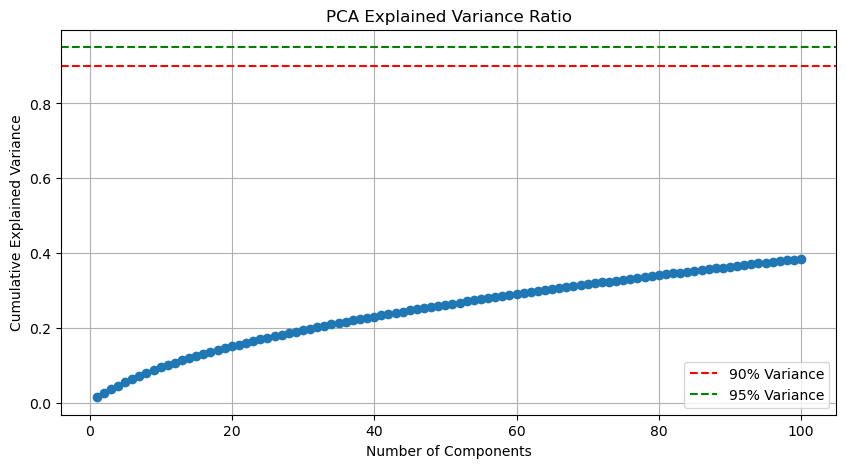

In [33]:
import matplotlib.pyplot as plt

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot variance vs number of components
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.axhline(y=0.90, color="r", linestyle="--", label="90% Variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.legend()
plt.grid()
plt.show()


In [34]:
# Find the minimum number of components needed for 90% and 95% variance
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
n_components_95 = np.argmax(explained_variance >= 0.95) + 1

print(f"Minimum components for 90% variance: {n_components_90}")
print(f"Minimum components for 95% variance: {n_components_95}")


Minimum components for 90% variance: 1
Minimum components for 95% variance: 1


In [35]:
optimal_components = n_components_90  # Use n_components_95 if needed
pca_optimal = PCA(n_components=optimal_components)
X_tfidf_pca_optimal = pca_optimal.fit_transform(df_tfidf)

# Save updated PCA-transformed data
import pickle

with open("../data/interim/tfidf_pca.pkl", "wb") as f:
    pickle.dump(X_tfidf_pca_optimal, f)

print(
    f"TF-IDF PCA Shape with {optimal_components} components: {X_tfidf_pca_optimal.shape}"
)


TF-IDF PCA Shape with 1 components: (2560, 1)


In [36]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_tfidf_umap = reducer.fit_transform(df_tfidf)

print(f"TF-IDF UMAP Shape: {X_tfidf_umap.shape}")


/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


TF-IDF UMAP Shape: (2560, 2)


In [37]:
with open("../data/interim/tfidf_umap.pkl", "wb") as f:
    pickle.dump(X_tfidf_umap, f)
print(f"TF-IDF UMAP Data Saved! Shape: {X_tfidf_umap.shape}")

TF-IDF UMAP Data Saved! Shape: (2560, 2)


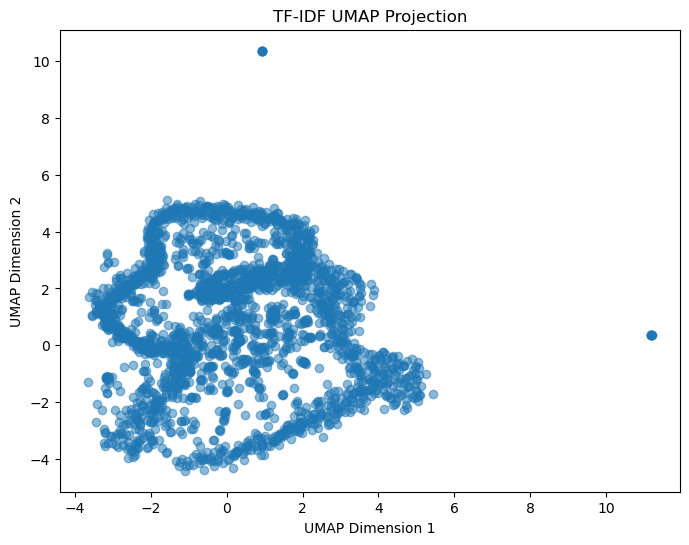

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tfidf_umap[:, 0], X_tfidf_umap[:, 1], alpha=0.5)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("TF-IDF UMAP Projection")
plt.show()

In [39]:
with open("../data/interim/word2vec_umap.pkl", "rb") as f:
    X_word2vec_umap = pickle.load(f)

print(f"Word2Vec UMAP Shape: {X_word2vec_umap.shape}")

Word2Vec UMAP Shape: (2560, 2)


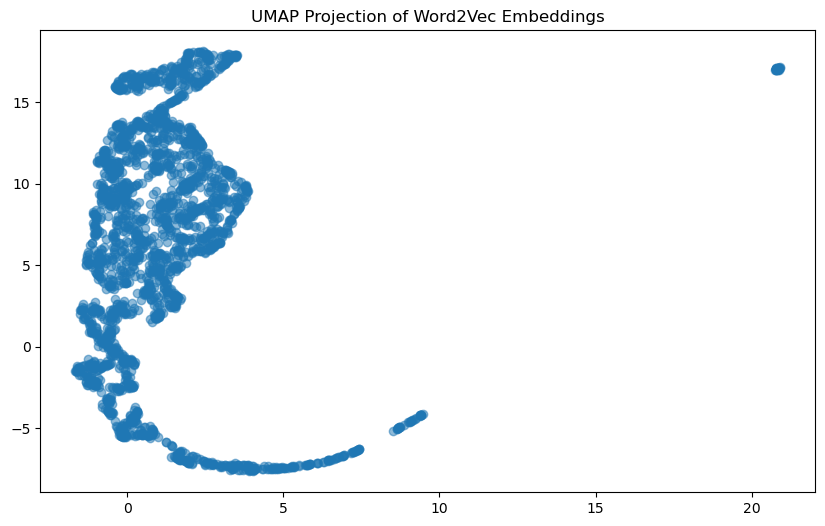

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(X_word2vec_umap[:, 0], X_word2vec_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection of Word2Vec Embeddings")
plt.show()

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


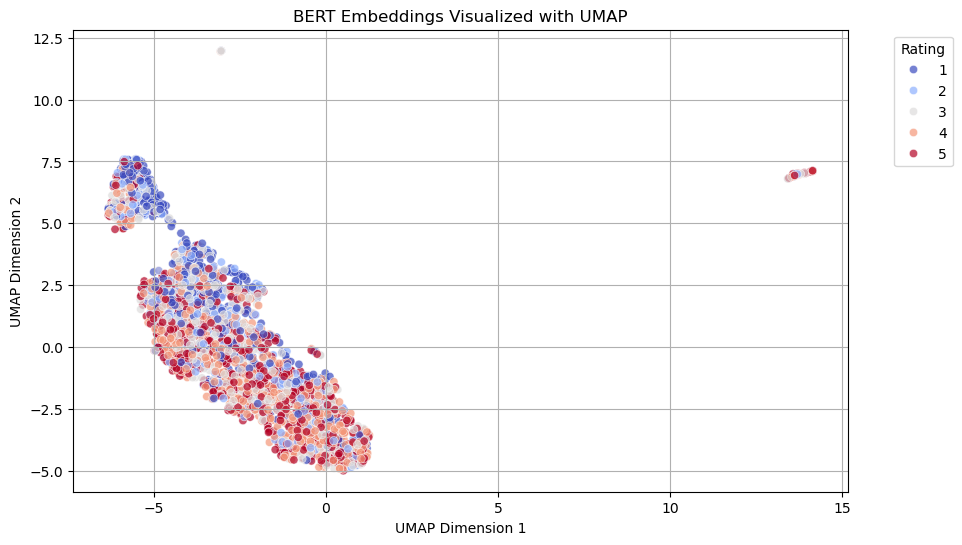

In [41]:
import seaborn as sns

reducer = umap.UMAP(n_components=2, random_state=42)
bert_umap = reducer.fit_transform(df_bert)

# Load the original dataset to get sentiment/ratings
df_reviews_path = "../data/processed/processed_reviews.csv"  # Adjust if needed
df_reviews = pd.read_csv(df_reviews_path)

# Ensure same length
df_reviews = df_reviews.iloc[: len(bert_umap)]

# Plot the UMAP representation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bert_umap[:, 0],
    y=bert_umap[:, 1],
    hue=df_reviews["rating"],
    palette="coolwarm",
    alpha=0.7,
)
plt.title("BERT Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


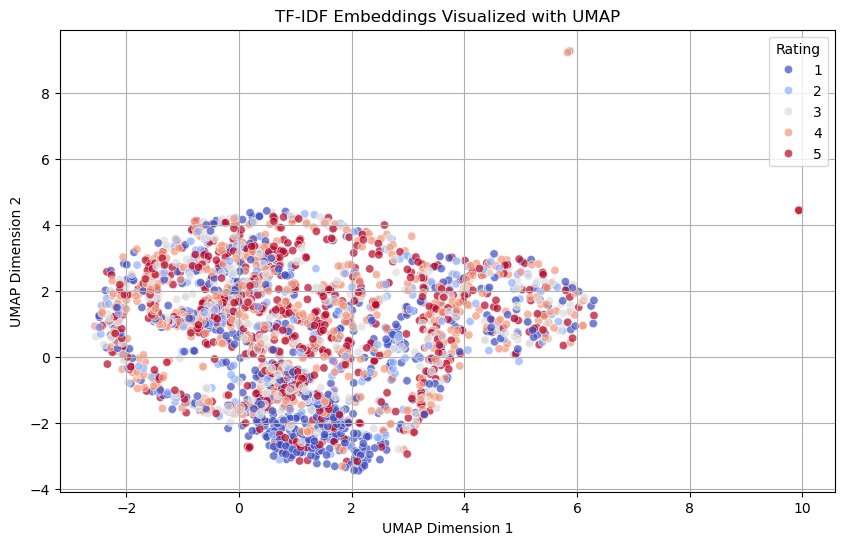

In [42]:
# Load the ratings data (ensuring alignment)
df_processed = pd.read_csv("../data/processed/processed_reviews.csv")
ratings = df_processed["rating"]

# Apply UMAP to reduce TF-IDF dimensions to 2D
reducer_tfidf = umap.UMAP(n_components=2, random_state=42)
X_tfidf_umap = reducer_tfidf.fit_transform(X_tfidf)

# Plot UMAP for TF-IDF embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tfidf_umap[:, 0],
    y=X_tfidf_umap[:, 1],
    hue=ratings,
    palette="coolwarm",
    alpha=0.7,
)
plt.title("TF-IDF Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating")
plt.grid()
plt.show()

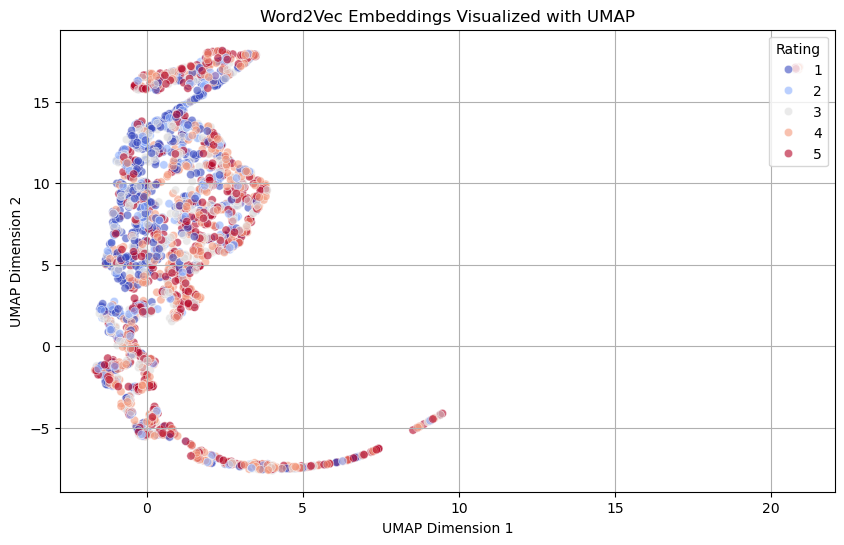

In [43]:
# Load Word2Vec UMAP embeddings
with open("../data/interim/word2vec_umap.pkl", "rb") as f:
    X_word2vec_umap = pickle.load(f)

# Load dataset to get ratings for coloring
df_processed = pd.read_csv("../data/processed/processed_reviews.csv")

# Ensure we have the correct number of rows
if X_word2vec_umap.shape[0] != df_processed.shape[0]:
    raise ValueError("Mismatch between embeddings and dataset size!")

# Plot UMAP visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_word2vec_umap[:, 0],
    y=X_word2vec_umap[:, 1],
    hue=df_processed["rating"],
    palette="coolwarm",
    alpha=0.6,
)
plt.title("Word2Vec Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating", loc="upper right")
plt.grid(True)
plt.show()